# Mean Reversion Strategy

1. [What is Mean Reversion](#what-is-mean-reversion)
2. [Types of Mean Reversion Series](#types-of-mean-reversion-series)
3. [How to Start Your Own Strategy](#how-to-start-your-own-strategy)
4. [Download Data](#download-data)
5. [Test Stationarity](#test-stationarity)
6. [Cointegration Test](#cointegration-test)
7. [Modeling the Strategy](#modeling-the-strategy)


# What is Mean Reversion

Mean Reversion refers to the concept that asset prices, or any financial series, tend to revert to their historical mean or average over time.

## Mean-Reverting Price Model (Ornstein-Uhlenbeck / OU Process)

The Ornstein-Uhlenbeck process is defined by the following stochastic differential equation:

$$
dX_t = \theta (\mu - X_t) \, dt + \sigma \, dW_t
$$

Where:
- X_t is the price at time t,
- μ is the long-term mean,
- θ is the speed of mean reversion,
- σ is the volatility,
- W_t is a Wiener process (white noise).


---

We can say that a **stationary time series** behaves in such a way that its:
- mean,
- variance, and
- autocorrelation

do not change over time.


---

# Types of Mean Reversion Series

- **Stationary Series**: These have constant statistical properties over time, such as mean and variance.
- **Non-Stationary Series**: These might trend or exhibit random walk behavior.

---

$$
X_t = \alpha + \beta Y_t + \varepsilon_t
$$

$$
X_t = A_1 X_{t-1} + A_2 X_{t-2} + \cdots + A_p X_{t-p} + \mu + \varepsilon_t
$$

$$
\Delta X_t = \Pi X_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta X_{t-i} + \mu + \varepsilon_t
$$


# How to Start Your Own Strategy

1. **Identify the Financial Instrument**
2. **Test for Stationarity**
3. **Develop Trading Rule**

---

# Download Data

Data can be downloaded from sources such as Yahoo Finance, Polygon, Metatrader...

---

[(1270483200, 24.57, 24.57, 24.45, 24.56, 2210, 0, 4247240000)
 (1270486800, 24.56, 24.66, 24.53, 24.62, 4482, 0, 8533000000)
 (1270490400, 24.62, 24.63, 24.58, 24.62,  936, 0, 1530050000) ...
 (1586376000, 15.79, 15.81, 15.66, 15.68, 1311, 0, 2678790000)
 (1586379600, 15.69, 15.88, 15.69, 15.86,  871, 0, 2387460000)
 (1586383200, 15.85, 15.9 , 15.73, 15.76, 2103, 0, 6029340000)]


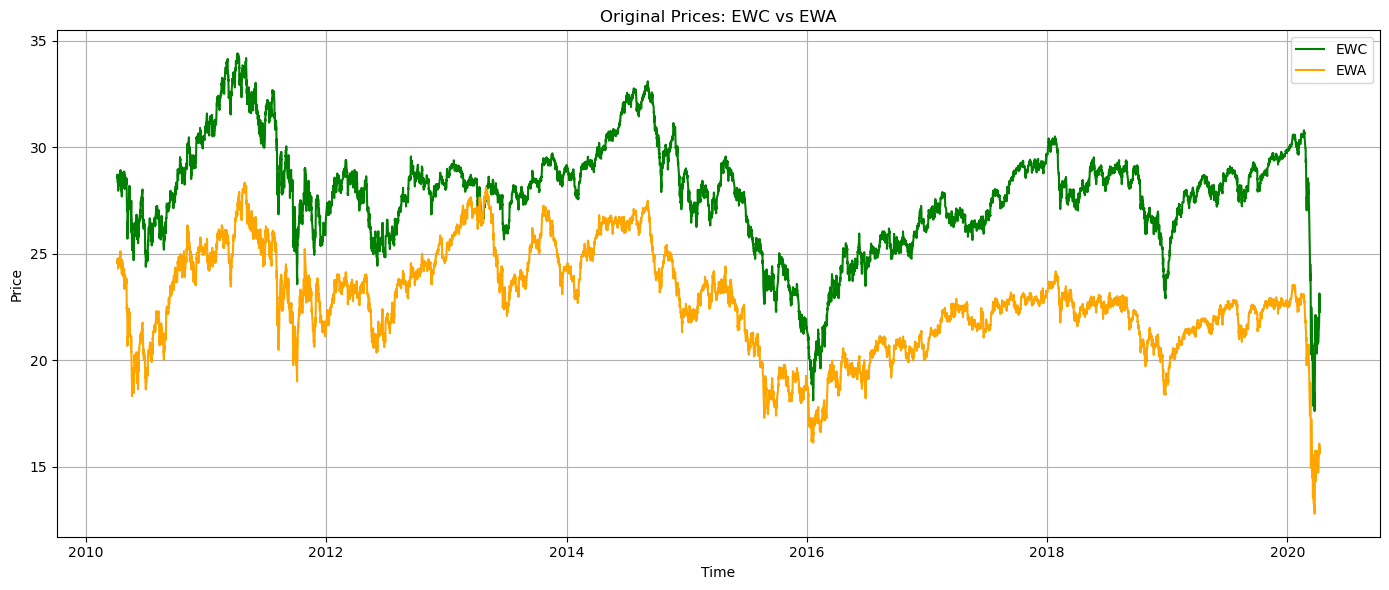

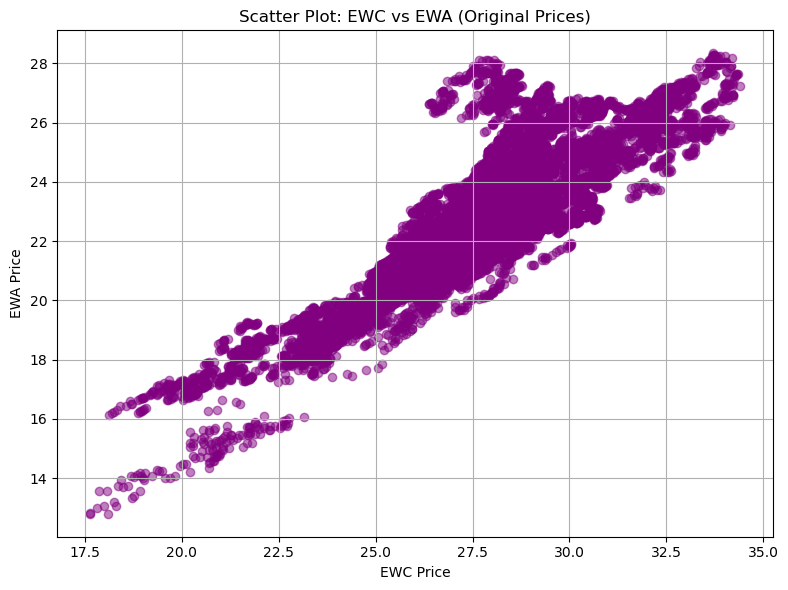

In [4]:
# ===========================================
# Import required libraries
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # For plotting
import MetaTrader5 as mt5
from datetime import datetime
import os
from dotenv import load_dotenv

# ===========================================
# Load environment variables
# ===========================================
load_dotenv()
MT5_LOGIN = os.getenv('MT5_LOGIN')
MT5_PWD = os.getenv('MT5_PWD')

# ===========================================
# Initialize and connect to MetaTrader 5
# ===========================================
mt5.initialize()
mt5.login(int(MT5_LOGIN), MT5_PWD, 'MetaQuotes-Demo')  # Adjust server if needed

# ===========================================
# Define time range and symbols
# ===========================================
from_date = datetime(2010, 4, 4)
to_date = datetime(2020, 4, 9)
symbol1 = "EWC"
symbol2 = "EWA"
timeframe = mt5.TIMEFRAME_H1  # 1-hour candles

# ===========================================
# Fetch historical data for each symbol
# ===========================================
bars_ewc = mt5.copy_rates_range(symbol1, timeframe, from_date, to_date)
bars_ewa = mt5.copy_rates_range(symbol2, timeframe, from_date, to_date)
print(bars_ewa)
# Convert to DataFrames
ewc = pd.DataFrame(bars_ewc)
ewa = pd.DataFrame(bars_ewa)

# Process dates
ewc['time'] = pd.to_datetime(ewc['time'], unit='s')
ewa['time'] = pd.to_datetime(ewa['time'], unit='s')

# Set the index as time
ewc.set_index('time', inplace=True)
ewa.set_index('time', inplace=True)

# Find common dates
common_dates = ewc.index.intersection(ewa.index)

# Filter both DataFrames by common dates
ewc = ewc.loc[common_dates]
ewa = ewa.loc[common_dates]

# Close connection with MT5
mt5.shutdown()

# ======== Plot original prices: EWC vs EWA ===========
plt.figure(figsize=(14, 6))
plt.plot(ewc['close'], label='EWC', color='green')
plt.plot(ewa['close'], label='EWA', color='orange')
plt.title('Original Prices: EWC vs EWA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Scatter plot of original prices: EWC vs EWA ===========
plt.figure(figsize=(8, 6))
plt.scatter(ewc['close'], ewa['close'], alpha=0.5, color='purple')
plt.title('Scatter Plot: EWC vs EWA (Original Prices)')
plt.xlabel('EWC Price')
plt.ylabel('EWA Price')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\jango\AppData\Local\Temp\ipykernel_3460\2587014609.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)


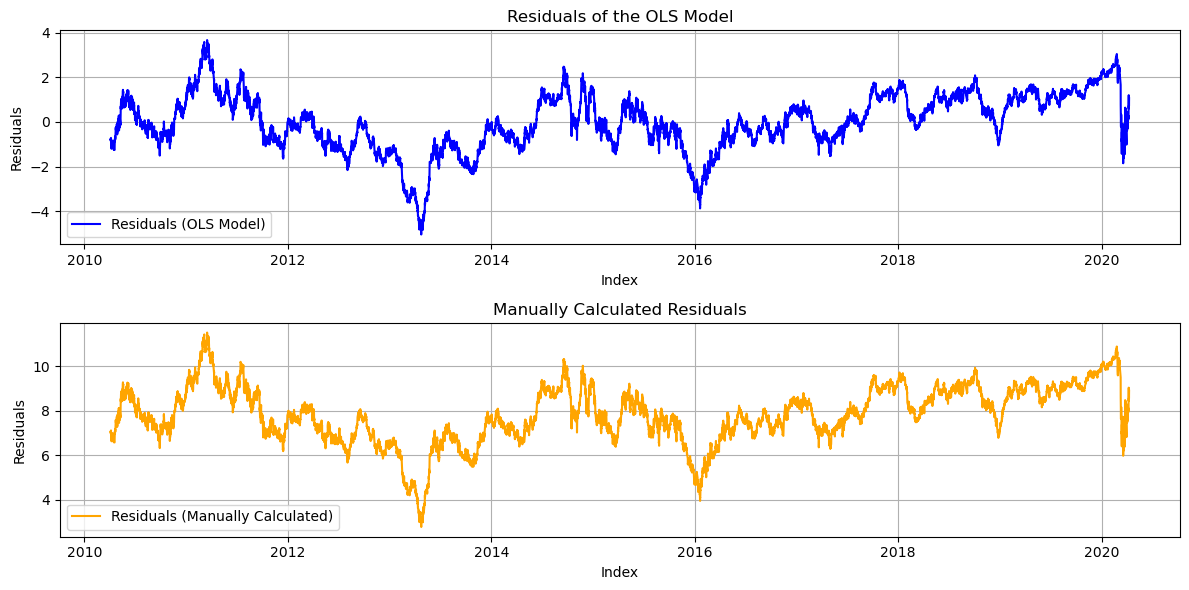

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from arch.__future__ import reindexing
from arch import unitroot

# Step 1: Define the dependent and independent variables
Y = ewc['close']
X = ewa['close']
X = sm.add_constant(X)  # Add an intercept (constant) to the model

# Step 2: Fit the OLS model
model = sm.OLS(Y, X).fit()
hedge_ratio = model.params[1]  # The coefficient of the second asset (EWA)
residuo = Y - hedge_ratio * ewa['close']  # Manually calculate the residuals using the hedge ratio

# residuals are the difference between the observed and predicted values from the model
residuals = model.resid  # Residuals from the OLS model

# Plot both the residuals from the OLS model and the manually calculated residuo
plt.figure(figsize=(12, 6))

# Plot residuals from the OLS model
plt.subplot(2, 1, 1)  # First plot
plt.plot(residuals, label='Residuals (OLS Model)', color='blue')
plt.title('Residuals of the OLS Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

# Plot manually calculated residuo
plt.subplot(2, 1, 2)  # Second plot
plt.plot(residuo, label='Residuals (Manually Calculated)', color='orange')
plt.title('Manually Calculated Residuals')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Test Stationarity

To test for stationarity, you can use the **Augmented Dickey-Fuller (ADF)** test (differents results depending on which is the independent variable).

---

## 📉 Mean Reversion Tests Overview

---

### 1. **ADF Test (Augmented Dickey-Fuller)**

The ADF test checks for **stationarity** in a time series by evaluating whether the series has a **unit root**.

We estimate an equation like:

$$
\Delta X_t = \alpha + \beta X_{t-1} + \varepsilon_t
$$

- If \( \beta < 0 \), this indicates a tendency to revert back to the mean.
- The **null hypothesis**: the series **has a unit root** (i.e., is non-stationary).
- We **reject** the null if the **p-value < 0.05**, supporting **mean reversion** or stationarity.

🧪 **Interpretation**:
- p-value < 0.05 → Likely stationary (mean-reverting)
- p-value ≥ 0.05 → Likely non-stationary (random walk)

---

### 2. **Hurst Exponent (H)**

The Hurst exponent measures the **long-term memory** of a time series.

- \( H < 0.5 \): Mean-reverting (anti-persistent)
- \( H = 0.5 \): Random walk (no memory)
- \( H > 0.5 \): Trending behavior (persistent)

🧪 **Interpretation**:
- \( H < 0.5 \): Series tends to revert to the mean  
- \( H = 0.5 \): Series behaves like white noise  
- \( H > 0.5 \): Series shows momentum/trend-following behavior  

---

### 3. **Variance Ratio (VR)**

The Variance Ratio test evaluates if the series follows a **random walk** by comparing variances at different lags.

- VR ≈ 1 → Random walk  
- VR < 1 → Mean-reversion  
- VR > 1 → Momentum

🧪 **Interpretation**:
- VR < 1 → Anti-persistence / mean-reversion  
- VR = 1 → Random walk  
- VR > 1 → Persistence / trend-following

---

### ✅ Combined Use

- ADF confirms if the series is **stationary**.
- Hurst Exponent shows if the series has **memory** (mean-reverting or trending).
- Variance Ratio detects **anti-persistent vs. persistent** behavior.

Use them **together** for more robust analysis.


In [6]:
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

# Assume 'residuals' is already a list or 1D array-like series of residuals
# Example: residuals = [values from your cointegration model]

# --- ADF Test ---
adf_result = adfuller(residuals)
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

print("ADF Test:")
print(f"Statistic: {adf_statistic}")
print(f"P-value: {adf_p_value}")
if adf_p_value < 0.05:
    print("Residuals are stationary (reject null hypothesis of unit root).")
else:
    print("Residuals are not stationary (fail to reject null hypothesis).")

# Ensure residuals are strictly positive
residuals1 = [r - min(residuals) + 1 for r in residuals]


# --- Hurst Exponent --- Not recomended for 
H, c, _ = compute_Hc(residuals1, kind='price')
print("\nHurst Exponent:")
print(f"H: {H}")
if H < 0.5:
    print("Series shows mean-reverting behavior.")
elif H > 0.5:
    print("Series shows trending behavior.")
else:
    print("Series behaves like a random walk.")

# --- Variance Ratio Test ---
vr_test = VarianceRatio(residuals1, lags=2)
print("\nVariance Ratio Test:")
print(f"Variance Ratio: {vr_test.vr}")
print(f"P-value: {vr_test.pvalue}")
if vr_test.vr < 1:
    print("Variance ratio suggests mean reversion.")
elif vr_test.vr > 1:
    print("Variance ratio suggests momentum.")
else:
    print("Variance ratio suggests random walk.")




ADF Test:
Statistic: -3.556303418488242
P-value: 0.006653509213151051
Residuals are stationary (reject null hypothesis of unit root).

Hurst Exponent:
H: 0.6867133860350688
Series shows trending behavior.

Variance Ratio Test:
Variance Ratio: 0.9660619380069909
P-value: 0.0011565026480382379
Variance ratio suggests mean reversion.


# Cointegration Test

You can use the **Engle-Granger** or **Johansen** test to check for cointegration between two time series (or more).

---

C:\Users\jango\AppData\Local\Temp\ipykernel_3460\2545194327.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  IGE['close'] = IGE['close'].fillna(method='ffill').fillna(method='bfill')  # Fill NaNs


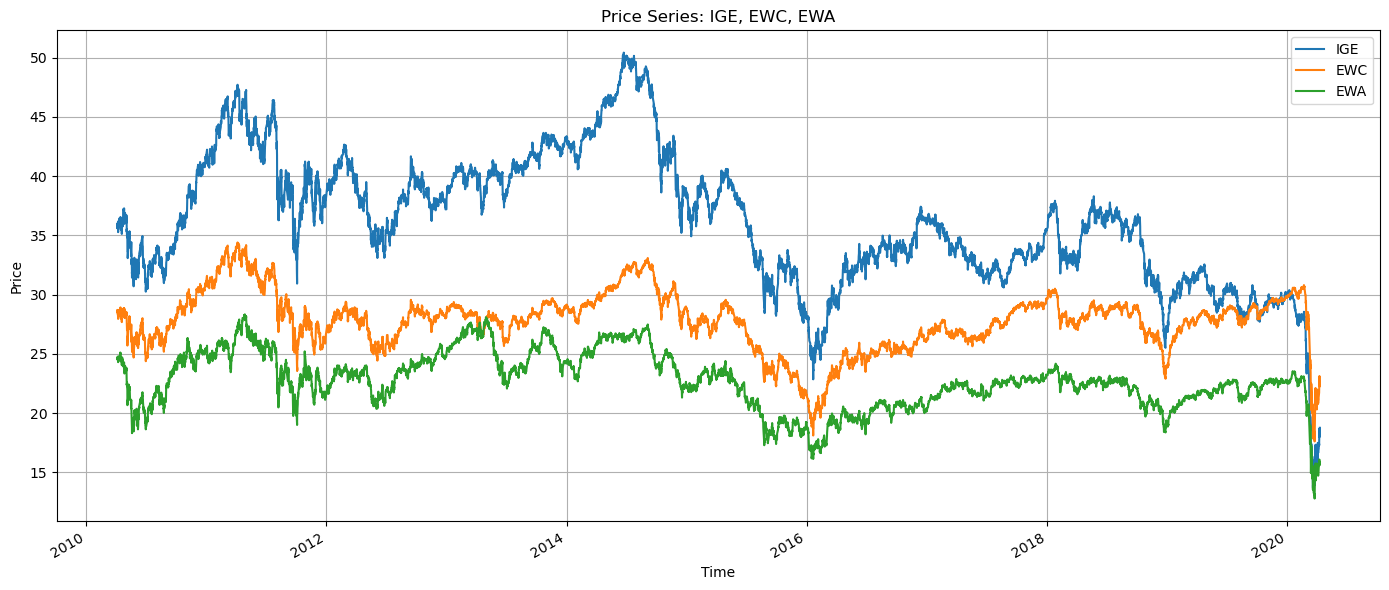


Eigenvalues: [1.76447349e-03 6.79690134e-04 2.68775590e-05]
Trace Statistic: [43.08908296 12.31597516  0.46834776]
Critical Values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Johansen Cointegration Test Interpretation:

Rank 0 Trace Statistic: 43.09
Critical Values - 90%: 27.07, 95%: 29.80, 99%: 35.46
=> Reject H0 at 99%: Cointegration exists at rank 0

Rank 1 Trace Statistic: 12.32
Critical Values - 90%: 13.43, 95%: 15.49, 99%: 19.93
=> Fail to reject H0: No cointegration at rank 1

Rank 2 Trace Statistic: 0.47
Critical Values - 90%: 2.71, 95%: 3.84, 99%: 6.63
=> Fail to reject H0: No cointegration at rank 2


In [12]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen


# Initialize and login to MT5
mt5.initialize()
mt5.login(int(MT5_LOGIN), MT5_PWD, 'MetaQuotes-Demo')

# Fetch IGE data
from_date = datetime(2010, 4, 4)
to_date = datetime(2020, 4, 9)
symbol3 = "IGE"
timeframe = mt5.TIMEFRAME_H1

bars_ige = mt5.copy_rates_range(symbol3, timeframe, from_date, to_date)
IGE = pd.DataFrame(bars_ige)
IGE['time'] = pd.to_datetime(IGE['time'], unit='s')
IGE.set_index('time', inplace=True)
IGE.sort_index(inplace=True)
IGE['close'] = IGE['close'].fillna(method='ffill').fillna(method='bfill')  # Fill NaNs

mt5.shutdown()



# Get common dates between all three series
common_dates = IGE.index.intersection(ewc.index).intersection(ewa.index)
IGE = IGE.loc[common_dates]
ewc = ewc.loc[common_dates]
ewa = ewa.loc[common_dates]

# Combine the series into a DataFrame
y3 = pd.concat([IGE['close'], ewc['close'], ewa['close']], axis=1)
y3.columns = ['IGE', 'EWC', 'EWA']

#graph
plt.figure(figsize=(14, 6))
y3.plot(ax=plt.gca())
plt.title('Price Series: IGE, EWC, EWA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['IGE', 'EWC', 'EWA'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Apply Johansen cointegration test
johansen_result = coint_johansen(y3, det_order=0, k_ar_diff=1)

# Print results
print("\nEigenvalues:", johansen_result.eig)
print("Trace Statistic:", johansen_result.lr1)
print("Critical Values (90%, 95%, 99%):\n", johansen_result.cvt)

# Interpretación automática de los resultados trace test vs valor crítico
print("\nJohansen Cointegration Test Interpretation:")
for i in range(len(johansen_result.lr1)):
    trace_stat = johansen_result.lr1[i]
    crit_vals = johansen_result.cvt[i]
    
    print(f"\nRank {i} Trace Statistic: {trace_stat:.2f}")
    print(f"Critical Values - 90%: {crit_vals[0]:.2f}, 95%: {crit_vals[1]:.2f}, 99%: {crit_vals[2]:.2f}")
    
    if trace_stat > crit_vals[2]:
        print("=> Reject H0 at 99%: Cointegration exists at rank", i)
    elif trace_stat > crit_vals[1]:
        print("=> Reject H0 at 95%: Cointegration exists at rank", i)
    elif trace_stat > crit_vals[0]:
        print("=> Reject H0 at 90%: Weak evidence of cointegration at rank", i)
    else:
        print("=> Fail to reject H0: No cointegration at rank", i)



## Half-Life for Mean Reverting Process

This section estimates the half-life of mean reversion for a stationary portfolio 
derived from cointegrated assets using the first eigenvector from the Johansen test.



In [13]:
# Assuming 'results.evec' is a numpy array and 'y3' is a pandas Series or DataFrame


evec_first = johansen_result.evec[:, 0]  # Extract the first eigenvector

# Multiply the eigenvector with the time series 'y3', repeat the eigenvector to match the shape of y3
# and sum the result across the specified axis (axis=1) to get 'yport'
yport = np.sum(np.tile(evec_first, (y3.shape[0], 1)) * y3, axis=1)

# Create the lagged version of 'yport' (equivalent to lag(yport, 1) in MATLAB)
ylag = pd.Series(yport).shift(1)

# Calculate deltaY (the difference between 'yport' and its lagged version)
deltaY = yport - ylag

# Remove the first value, which is NaN due to the lag
deltaY = deltaY[1:]
ylag = ylag.dropna()  # Drop the NaN value from the lagged series

# Fit an OLS (Ordinary Least Squares) regression model
X = sm.add_constant(ylag)  # Add the constant term (intercept) to the independent variable
model = sm.OLS(deltaY, X)  # Create the OLS model with deltaY as the dependent variable and ylag as the independent variable
results_ols = model.fit()  # Fit the model

# Get the hedge ratio (beta[1]), which represents the coefficient for the lagged series
hedge_ratio = results_ols.params[0]

# Calculate the half-life, which is the time it takes for the hedge ratio to halve
half_life = -np.log(2) / hedge_ratio

# Print the hedge ratio and the half-life in days
print(f'Hedge Ratio: {hedge_ratio}')
print(f'Half-Life: {half_life/24} days')



Hedge Ratio: -0.003199476653954149
Half-Life: 9.026830212259128 days


# Modeling the Strategy

You will use techniques such as z-scores, Bollinger Bands, and linear regression to model your strategy.

---

In [44]:


# Assume y3 is a (T x N) matrix of ETF prices: EWA, EWC, IGE
# Assume results.evec[:, 0] is the first eigenvector from a PCA or similar
# Define transaction cost per unit of capital (e.g., 0.1% = 0.001)

transaction_cost_rate = 0.001

# Step 1: Compute the portfolio value as the weighted sum of asset prices
yport = np.dot(y3, johansen_result.evec[:, 0])


# Step 2: Use the previously computed half-life as lookback period
lookback = round(half_life)

# Step 3: Define moving average and moving standard deviation functions
def moving_avg(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).mean().values

def moving_std(x, window):
    return pd.Series(x).rolling(window=window, min_periods=1).std().values

# Step 4: Compute z-score as signal (mean-reverting strategy)
zscore = (yport - moving_avg(yport, lookback)) / moving_std(yport, lookback)
entry_threshold = 1 # Only trade when z-score exceeds ±1

numUnits = np.where(np.abs(zscore) > entry_threshold, -zscore, 0)


# Step 5: Compute positions (capital allocation) for each ETF
# Each row in positions is the capital invested in each asset
positions = np.outer(numUnits, johansen_result.evec[:, 0]) * y3


# Step 6: Define lagging function (to avoid look-ahead bias)
def lag_matrix(mat, lag=1):
    lagged = np.roll(mat, lag, axis=0)
    lagged[:lag, :] = np.nan  # set initial values to NaN
    return lagged

# Step 7: Compute daily P&L (profit and loss)
positions_lag = lag_matrix(positions)
# Calculate change in positions (delta)
position_change = np.diff(positions_lag, axis=0, prepend=np.zeros((1, positions_lag.shape[1])))
position_change_clean = np.nan_to_num(position_change, nan=0.0)

# Daily transaction costs: abs(delta) * transaction cost rate
transaction_costs = np.nansum(np.abs(position_change_clean) * transaction_cost_rate, axis=1)
y3_lag = lag_matrix(y3)
daily_returns = (y3 - y3_lag) / y3_lag
pnl = np.nansum(positions_lag * daily_returns, axis=1)
# Adjust P&L by subtracting transaction costs
pnl_net = pnl - transaction_costs


# Step 8: Compute daily return: P&L divided by gross market value
gross_market_value = np.nansum(np.abs(positions_lag), axis=1)
ret = np.divide(pnl_net, gross_market_value, out=np.zeros_like(pnl_net), where=gross_market_value!=0)


# Step 9: Summary statistics
print(f"Average daily return: {np.nanmean(ret):.5f}")
print(f"Daily volatility: {np.nanstd(ret):.5f}")
print(f"Daily Sharpe ratio: {np.nanmean(ret)/np.nanstd(ret):.2f}")


# Drop NaNs for plotting
ret_clean = pd.Series(ret).dropna()

# Daily statistics
mean_daily_ret = np.mean(ret_clean)
std_daily_ret = np.std(ret_clean)



Average daily return: -0.00004
Daily volatility: 0.00137
Daily Sharpe ratio: -0.03


# Strategy Results and interpretation

Evaluate the strategy's performance using metrics like returns, Sharpe ratio, and drawdowns.

Annualized Return: -0.95%
Annualized Volatility: 2.18%
Annualized Sharpe Ratio: -0.44


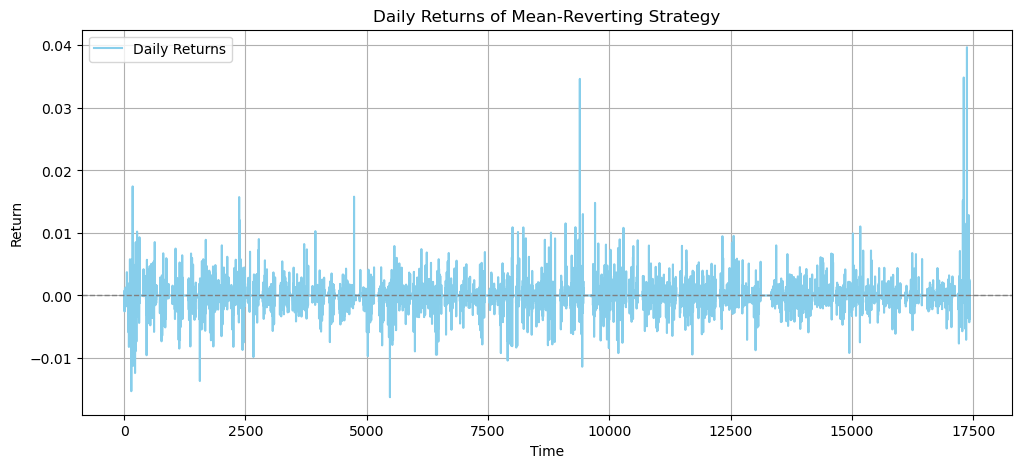

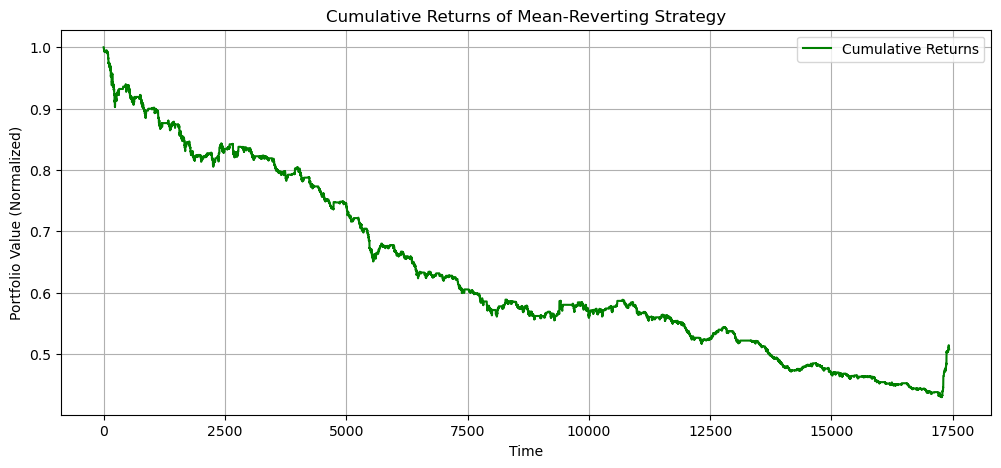

In [45]:
# Daily statistics
mean_daily_ret = np.mean(ret_clean)
std_daily_ret = np.std(ret_clean)

# Annualized statistics
annualized_return = (1 + mean_daily_ret)**252 - 1
annualized_volatility = std_daily_ret * np.sqrt(252)
sharpe_ratio_annual = annualized_return / annualized_volatility

# Output
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Annualized Sharpe Ratio: {sharpe_ratio_annual:.2f}")

# Plot daily returns
plt.figure(figsize=(12, 5))
plt.plot(ret_clean.index, ret_clean, label='Daily Returns', color='skyblue')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Daily Returns of Mean-Reverting Strategy')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative returns
cumulative_returns = (1 + ret_clean).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Returns', color='green')
plt.title('Cumulative Returns of Mean-Reverting Strategy')
plt.xlabel('Time')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.grid(True)
plt.show()


# Strategy Evaluation

## Negative Annualized Return
The strategy now shows an **annualized return of -0.95%**, meaning it is **losing money on average each year**.  
This clearly indicates that the current signals are not capturing profitable opportunities.

## Low Volatility but Negative Sharpe
Despite a **low annualized volatility of 2.18%**, the **Sharpe ratio of -0.44** indicates that the returns are negative relative to risk.  
Even small positions or trades are **not generating compensation for the risk taken**, making the strategy unattractive.

## Daily Returns Near Zero
The daily average returns are effectively negligible.  
This suggests that the model fails to exploit mean-reversion effectively, possibly due to **structural changes in asset relationships** over the period.

## Signal or Parameter Issues
- The **half-life estimation** or the **use of the first principal component (PCA)** may not be producing a strong mean-reverting signal.
- The portfolio combination may **not exhibit sufficiently stationary or cointegrated behavior**.
- Negative returns suggest the strategy might be **trading against the true underlying dynamics**.

## Transaction Costs Impact
With such low returns and a negative P&L, including **transaction costs** (spreads, commissions) would further **worsen performance**, likely increasing annual losses.

## Asset Selection and Period
- The ETFs **EWA, EWC, IGE** may not be well-suited for this type of mean-reversion strategy.
- Relationships may **not be stable or cointegrated** over the sampled period.
- Consider **re-evaluating asset choice** or **training window** for more reliable signals.

# Recommendations for Improvement
- **Check for cointegration** between assets using statistical tests like **ADF or Johansen** to ensure the portfolio combination is stationary.
- **Use cointegration vectors** instead of PCA for constructing the portfolio.
- **Optimize the lookback period** or implement a **dynamic/adaptive z-score** calculation.
- Include **mechanical stop-loss and take-profit rules** to reduce negative drift.
- Examine the **skewness and mean behavior** of the signal to avoid systematic bias.
- Consider **alternative assets or asset pairs** that exhibit stronger mean-reverting behavior over the chosen period.
- Evaluate **transaction cost sensitivity**, as the current low-return strategy is highly vulnerable.
